# Chapter 9 Exercise 9

In [1]:
import sys
sys.path.append('..')

from scipy.stats import norm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from chapters.chapter7 import CI
from chapters.chapter8 import bootstrap, bootstrap_variance
from chapters.chapter9 import parametric_bootstrap, parametric_bootstrap_variance

%load_ext autoreload
%autoreload 2

%matplotlib inline
plt.style.use('ggplot')

In [2]:
z = norm(0, 1)
alpha = 0.05
z_alpha = np.abs(z.ppf(alpha/2))
z_alpha

1.9599639845400545

# Parameters

Create 100 iid $N(\mu, 1)$ observations.  The parameter $\mu$ is treated as unknown but we use $\mu = 5$ for this excercise.

In [3]:
mu = 5
n = 100
dist = norm(mu, 1)
seed_true = 84849898
obs = pd.Series(dist.rvs(size=n, random_state=seed_true), name='observations')
obsexp = np.exp(obs)
obsexp.head()

0    197.436807
1    207.916547
2    444.637774
3    374.092839
4     30.066349
Name: observations, dtype: float64

The MLE for the mean of a normal random variable is the sample mean.

In [4]:
mu_hat = obs.mean()
mu_hat

4.9113996759565284

The true value we want to estimate is $e^5$.

In [5]:
theta = np.exp(5)
theta

148.4131591025766

The delta method tells us that the MLE for $e^\mu$ is simply $\hat \theta = e^{\bar X_n}$.

In [6]:
theta_hat = np.exp(mu_hat)
theta_hat

135.82939856268032

Note that the mean of the exponential is not the exponential of the mean.

In [36]:
np.mean(np.exp(obs))

206.45870133916532

In [37]:
np.exp(np.mean(obs))

135.82939856268032

# Confidence Intervals

In [7]:
statistic = lambda os: np.exp(np.mean(os))
statistic(obs)

135.82939856268032

In [8]:
seed_boot = 22189
se_boot = np.sqrt(bootstrap_variance(obs, statistic, 10000, random_state=seed_boot))
se_boot

13.058332203312172

In [9]:
ci_boot = CI(theta_hat - z_alpha*se_boot, theta_hat + z_alpha*se_boot)
ci_boot

CI(lower=110.23553774602888, upper=161.42325937933177)

For the parametric bootstrap, we draw out bootstrap samples from $N(\bar X_n, 1)$.

In [10]:
dist_hat = norm(mu_hat, 1)
seed_pboot = 8874545
se_pboot = np.sqrt(parametric_bootstrap_variance(dist_hat, n, statistic, 10000, random_state=seed_pboot))
se_pboot

13.559807493731968

In [11]:
ci_pboot = CI(theta_hat - z_alpha*se_pboot, theta_hat + z_alpha*se_pboot)
ci_pboot

CI(lower=109.25266423766932, upper=162.40613288769131)

For the delta method, note that the fisher information for $\hat \mu$ is n = 100 (see example 9.21).  The corresponding se is $\sqrt(1/100) = 1/10$. It follows that the se for $\hat \theta$ is $e^{\bar X} / 10$.

In [12]:
se_delta = theta_hat / np.sqrt(n)
se_delta

13.582939856268032

In [13]:
ci_delta = CI(theta_hat - z_alpha*se_delta, theta_hat + z_alpha*se_delta)
ci_delta

CI(lower=109.20732564022131, upper=162.45147148513934)

We can check if our confidence intervals contain the true value.

In [26]:
ci_boot.lower <= theta <= ci_boot.upper

True

In [25]:
ci_pboot.lower <= theta <= ci_pboot.upper

True

In [24]:
ci_delta.lower <= theta <= ci_delta.upper

True

# Comparison of Distributions

Let's compare the histograms.

In [17]:
df_true = pd.DataFrame({'value': np.exp(dist.rvs(size=n, random_state=seed_true))})
df_true['variable'] = 'true'
df_true.head()

,value,variable
0,197.436807,true
1,207.916547,true
2,444.637774,true
3,374.092839,true
4,30.066349,true


In [18]:
df_boot = pd.DataFrame({'value': list(bootstrap(obs, statistic, 10000, random_state=seed_boot))})
df_boot['variable'] = 'bootstrap'
df_boot.head()

,value,variable
0,145.099664,bootstrap
1,130.238586,bootstrap
2,113.260932,bootstrap
3,110.778414,bootstrap
4,121.017674,bootstrap


In [19]:
df_pboot = pd.DataFrame({'value': list(parametric_bootstrap(dist_hat, n, statistic, 10000, random_state=seed_pboot))})
df_pboot['variable'] = 'parametric bootstrap'
df_pboot.head()

,value,variable
0,140.662596,parametric bootstrap
1,142.131512,parametric bootstrap
2,142.253847,parametric bootstrap
3,133.418525,parametric bootstrap
4,124.157156,parametric bootstrap


In [20]:
seed_delta = 3654
df_delta = pd.DataFrame({'value': norm(theta_hat, se_delta**2).rvs(n, random_state=seed_delta)})
df_delta['variable'] = 'delta'
df_delta.head()

,value,variable
0,-288.550118,delta
1,166.103050,delta
2,126.866502,delta
3,51.488514,delta
4,130.686266,delta


In [21]:
df = pd.concat((df_true, df_boot, df_pboot, df_delta))
df.sample(10)

,value,variable
6017,145.758429,parametric bootstrap
9353,153.841775,bootstrap
1041,124.423382,parametric bootstrap
1514,131.582991,parametric bootstrap
1473,137.074091,bootstrap
5678,114.873900,parametric bootstrap
887,127.513597,parametric bootstrap
1239,143.298500,parametric bootstrap
9707,151.647735,bootstrap
4874,150.387275,parametric bootstrap


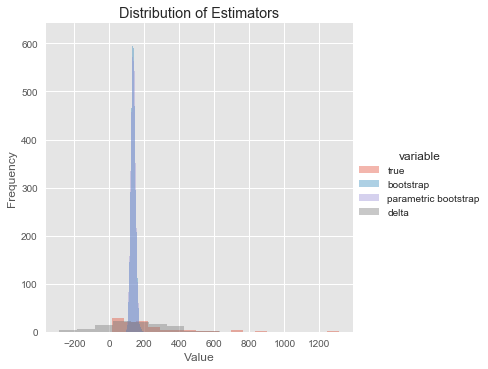

In [35]:
g = sns.FacetGrid(df, hue='variable', size=5)
g.map(sns.distplot, 'value', kde=False).add_legend()
g.set(xlabel='Value', ylabel='Frequency', title='Distribution of Estimators')
g.savefig('../images/ch09q09_histogram.svg')

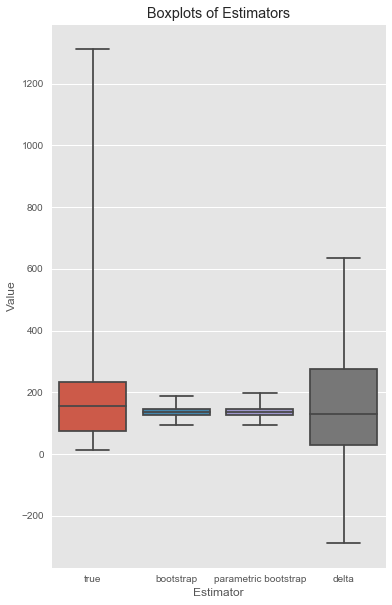

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(6, 10))
g = sns.boxplot('variable', 'value', data=df, ax=ax, whis=99999)
g.set(ylabel='Value', xlabel='Estimator', title='Boxplots of Estimators')
g.figure.savefig('../images/ch09q09_boxplot.svg')

Both bootstrap methods give very tight approximations.  The delta method is worse.